In [23]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
# import pickle
from matplotlib import style
import time

style.use("ggplot")

SIZE = 10  #遊戲環境大小

HM_EPISODES = 30000
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD = 25
epsilon = 0.9
EPS_DECAY = 0.9998  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 3000  # how often to play through env visually.

start_q_table = None # None or Filename

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1  # player key in dict
FOOD_N = 2  # food key in dict
ENEMY_N = 3  # enemy key in dict

#遊戲中顯示的顏色
# BGR 

d = {1: (255, 255, 255),   #白色
     2: (0, 255, 255),      #黃色
     3: (0, 0, 255)}      #紅色




In [27]:
## observation 是 blob 相對於食物、敵人的位置

## 建立 Agent:blob

class Blob:
    def __init__(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)
    
    # print blob location (overwrite)  
    def __str__(self):
        return f"{self.x}, {self.y}"   

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)

    def action(self, choice):
        '''
        Gives us 4 total movement options. (0,1,2,3) 設定是斜著走XD
        '''
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)

    def move(self, x=False, y=False):

        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y


        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1


In [25]:
if start_q_table is None:
    # initialize the q-table#
    q_table = {}
    for i in range(-SIZE+1, SIZE):
        for ii in range(-SIZE+1, SIZE):
            for iii in range(-SIZE+1, SIZE):
                    for iiii in range(-SIZE+1, SIZE):
                        q_table[((i, ii), (iii, iiii))] = [np.random.uniform(-5, 0) for i in range(4)]
                        
                        

In [8]:
## 看看我們的 q_table

print(q_table[((-9, -2), (3, 9))])

[-0.5914654542922868, -0.268229499943307, -2.0653597991604866, -4.862148676598989]


on #0, epsilon is 0.9
3000 ep mean: nan
on #3000, epsilon is 0.49390083359356435
3000 ep mean: -174.19566666666665
on #6000, epsilon is 0.27104225936046566
3000 ep mean: -112.61933333333333
on #9000, epsilon is 0.14874221981913022
3000 ep mean: -85.382
on #12000, epsilon is 0.08162656262136181
3000 ep mean: -68.31333333333333
on #15000, epsilon is 0.044794919246742226
3000 ep mean: -57.142
on #18000, epsilon is 0.024582497729691496
3000 ep mean: -48.17
on #21000, epsilon is 0.01349035124500733
3000 ep mean: -41.952666666666666
on #24000, epsilon is 0.0074032174726434705
3000 ep mean: -33.167
on #27000, epsilon is 0.004062728090014504
3000 ep mean: -30.140333333333334


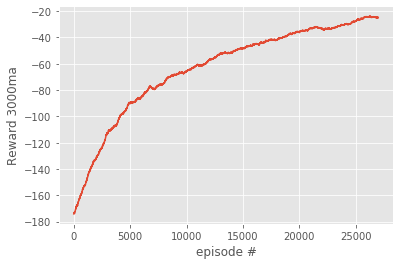

In [28]:


episode_rewards = []

for episode in range(HM_EPISODES):
    player = Blob()
    food = Blob()
    enemy = Blob()
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, epsilon is {epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False

    episode_reward = 0
    for i in range(200):
        obs = (player-food, player-enemy)
    
        if np.random.random() > epsilon:
            # GET THE ACTION
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 4)
        # Take the action!
        player.action(action)

        ############## 定義每走一個 action後的 rewards ###

        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
            
        # 得到 rewards 後，取得新的 observation
        
        new_obs = (player-food, player-enemy)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]

        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        elif reward == -ENEMY_PENALTY:
            new_q = -ENEMY_PENALTY
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[obs][action] = new_q

        if show:
            
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8) #黑色的背景
            
            env[food.x][food.y] = d[FOOD_N]  # food 顯示黃色
            env[player.x][player.y] = d[PLAYER_N]  # player顯示白色
            env[enemy.x][enemy.y] = d[ENEMY_N]  # enemy 顯示紅色
            img = Image.fromarray(env, 'RGB')  
            img = img.resize((300, 300))  
            cv2.imshow("image", np.array(img))  # show it!
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:  
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        episode_reward += reward
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            break

    #print(episode_reward)
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()
